# Exploratory Data Analysis and Cleaning

* Suspect values and NaN's have been imputed. 
* Visualization provided when appropriate.
* Two features, date_recorded and construction_year, have been synthesized into one engineered feature, years elapsed.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%run -i imputing_functions.py

In [2]:
TRAIN_FEATURES = '../data/external/pump-it-up-training-features.csv'
TRAIN_LABELS = '../data/external/pump-it-up-training-labels.csv'
#TRAIN_FEATURES = '../data/external/pump-it-up-test-features.csv'

train_features = pd.read_csv(TRAIN_FEATURES)
train_labels = pd.read_csv(TRAIN_LABELS)
train_full = pd.merge(train_features, train_labels, on='id')

REGIONS = train_features['region'].unique().tolist()
DISTRICTS = train_features['district_code'].unique().tolist()
SEED = 42
NUM_WELLS_TRAINING = train_features.shape[0]

sns.set_palette('colorblind')

# First Look

In [3]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13981 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [4]:
# Number of NaN values in features that have NaN's
feature_na_counts = pd.isna(train_features).sum()
feature_na_counts[feature_na_counts != 0]

funder                869
installer             877
subvillage             99
public_meeting        821
scheme_management     969
scheme_name          7092
permit                737
dtype: int64

In [5]:
# Number of zeros in features that have zeros
features = list(train_features.columns)

for feature in features:
    num_zeros = (train_features[feature] == 0).sum()
    if num_zeros > 0:
        print(feature, num_zeros)

amount_tsh 10410
gps_height 5211
longitude 457
num_private 14656
district_code 4
population 5453
public_meeting 1291
permit 4359
construction_year 5260


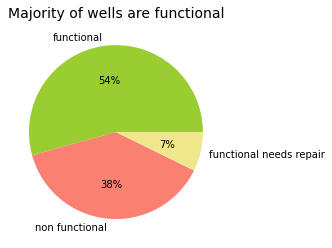

In [6]:
# Majority of wells are 'functional' and only a few are 'functional needs repair'
label_dist = train_labels['status_group'].value_counts(normalize=True)
plt.pie(label_dist, 
        labels = label_dist.index,
        colors = ['yellowgreen', 'salmon', 'khaki'],
        autopct='%.0f%%')
plt.title('Majority of wells are functional', size=14)
plt.show()

# Examining Features

## amount_tsh

In [7]:
train_features['amount_tsh'].describe()

count     14850.000000
mean        322.826983
std        2510.968644
min           0.000000
25%           0.000000
50%           0.000000
75%          25.000000
max      200000.000000
Name: amount_tsh, dtype: float64

In [8]:
train_features.loc[train_features['amount_tsh'] == 0, 'amount_tsh'] = np.nan
fill_na_median_area(df=train_features, num_col='amount_tsh')

## date_recorded
date_recorded will become synthesized along with construction_year into synthetic feature, years_elapsed.

## funder

In [9]:
train_features['funder'] = train_features['funder'].str.lower()
train_features['funder'] = train_features['funder'].str.replace('  ', ' ')
train_features.loc[train_features['funder'] == '0', 'funder'] = np.nan

In [10]:
single_occurences_to_other(df=train_features, col='funder')

In [11]:
replace_na_region_district_mode(train_features, 'funder')
replace_na_region_mode(train_features, 'funder')
dataset_mode = train_features['funder'].mode()[0]
train_features['funder'].fillna(dataset_mode, inplace=True)

In [12]:
top_ten_funders = train_features['funder'].value_counts()[:10]
top_ten_funders = pd.DataFrame(top_ten_funders)
top_ten_funders.rename(columns = {'funder':'wells_funded'}, 
                       inplace = True)
top_ten_funders['percent_funded'] = top_ten_funders['wells_funded'] / NUM_WELLS_TRAINING * 100

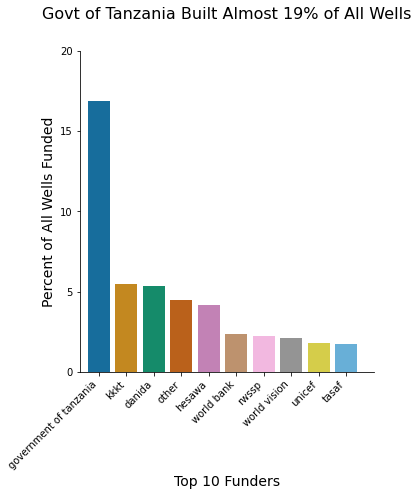

In [13]:
sns.catplot(data=top_ten_funders,
            x=top_ten_funders.index,
            y='percent_funded',
            kind='bar',
            ci=None)
plt.title('Govt of Tanzania Built Almost 19% of All Wells', 
          size=16,
          y=1.08)
plt.xlabel('Top 10 Funders', size=14)
plt.xticks(rotation=45, ha='right')
plt.xlim(-0.7, top_ten_funders.shape[0])
plt.ylabel('Percent of All Wells Funded', size=14)
plt.ylim(0, 20)
plt.yticks([0, 5, 10, 15, 20])
plt.show()

## gps_height

In [14]:
train_features['gps_height'].describe()

count    14850.000000
mean       655.147609
std        691.261185
min        -57.000000
25%          0.000000
50%        344.000000
75%       1308.000000
max       2777.000000
Name: gps_height, dtype: float64

In [15]:
# Impute zeros with median since Tanzania is mountainous country
train_features.loc[train_features['gps_height'] == 0, 'gps_height'] = np.nan
fill_na_median_area(df=train_features, num_col='gps_height')

## installer

In [16]:
train_features['installer'] = train_features['installer'].str.lower()
train_features['installer'] = train_features['installer'].str.replace('  ', ' ')
train_features.loc[train_features['installer'] == '0', 'installer'] = np.nan

In [17]:
single_occurences_to_other(df=train_features, col='installer')

In [18]:
replace_na_region_district_mode(train_features, 'installer')
replace_na_region_mode(train_features, 'installer')
dataset_mode = train_features['installer'].mode()[0]
train_features['installer'].fillna(dataset_mode, inplace=True)

## latitude and longitude

In [19]:
# 1812 observations from two regions have longitude and latitude of
# zero, which is outside Tanzania.
train_features.loc[(train_features['latitude'] > -0.1), 'latitude'] = 0
train_features.loc[train_features['latitude'] == 0, 'latitude'] = np.nan
train_features.loc[train_features['longitude'] == 0, 'longitude'] = np.nan

In [20]:
print(train_features['latitude'].isna().sum())
print(train_features['longitude'].isna().sum())

457
457


In [21]:
fill_na_mean_area(df=train_features, num_col='latitude')
fill_na_mean_area(df=train_features, num_col='longitude')

No handles with labels found to put in legend.


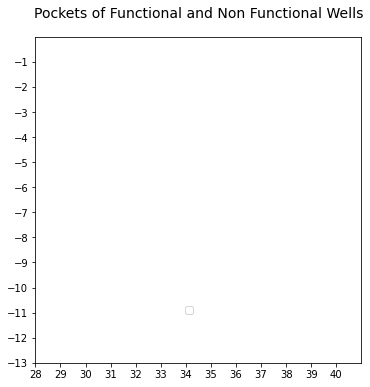

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))

palette ={'functional': 'mediumseagreen',
          'functional needs repair': 'yellow',
          'non functional': 'red'} 

sns.scatterplot(data=train_full, 
                    x='longitude', 
                    y='latitude', 
                    hue='status_group',
                    palette=palette,
                    style='status_group',
                    alpha=0.2)

ax.set_title('Pockets of Functional and Non Functional Wells',
             size=14,
             y=1.04)
ax.legend(bbox_to_anchor= (0.5, 0.19))
ax.set_xlim(28, 41)
ax.set_xticks(range(28, 41))
ax.set_ylim(-13, 0)
ax.set_yticks(range(-13, 0))
ax.set_aspect(aspect=1)
plt.show()

## wpt_name

In [23]:
train_features['wpt_name'].value_counts()

none                    877
Shuleni                 435
Zahanati                204
Msikitini               112
Sokoni                   68
                       ... 
Kwa Msuri                 1
Dawa Msanfwa              1
Mahagashi                 1
Kwa Ndagabisa             1
Shuleni Mwalinha P/S      1
Name: wpt_name, Length: 10840, dtype: int64

## num_private

In [24]:
percent_num_private_zero = (train_features['num_private'] == 0).sum() / NUM_WELLS_TRAINING * 100
print('{}% of num_private values are zero'.format(round(percent_num_private_zero, 2)))

98.69% of num_private values are zero


## basin

In [25]:
print(train_features['basin'].describe(), '\n')
print('Basins:', train_features['basin'].unique().tolist())

count             14850
unique                9
top       Lake Victoria
freq               2623
Name: basin, dtype: object 

Basins: ['Internal', 'Pangani', 'Ruvuma / Southern Coast', 'Rufiji', 'Lake Victoria', 'Lake Tanganyika', 'Wami / Ruvu', 'Lake Rukwa', 'Lake Nyasa']


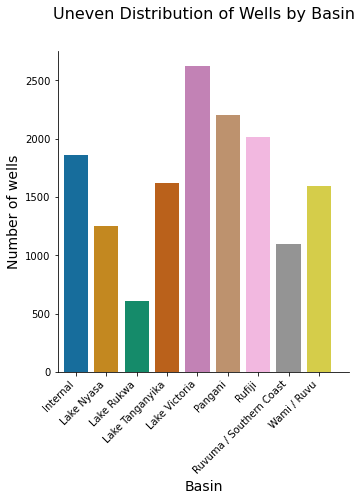

In [26]:
wells_by_basin = pd.DataFrame(train_features.groupby('basin')['id'].count())

sns.catplot(data=wells_by_basin,
            x=wells_by_basin.index,
            y='id',
            kind='bar',
            ci=None)
plt.title('Uneven Distribution of Wells by Basin', 
          size=16,
          y=1.08)
plt.xlabel('Basin', size=14)
plt.xticks(rotation=45, ha='right')
plt.xlim(-0.6, wells_by_basin.shape[0])
plt.ylabel('Number of wells', size=14)
plt.show()

## subvillage

In [27]:
# Wards are next smallest geographic area in Tanzania. Sometimes 
# (like in cities) the ward and the village are the same.
train_features['subvillage'].fillna(train_features['ward'], inplace=True)

## region and region_code

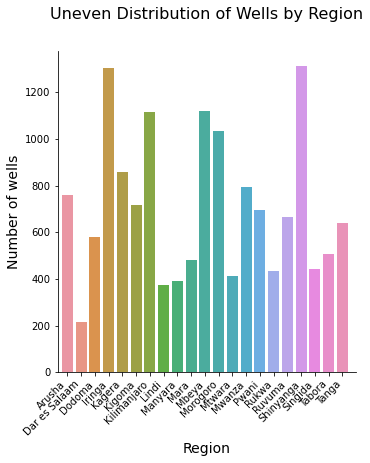

In [28]:
wells_by_region = pd.DataFrame(train_features.groupby('region')['id'].count())

sns.catplot(data=wells_by_region,
            x=wells_by_region.index,
            y='id',
            kind='bar',
            ci=None)
plt.title('Uneven Distribution of Wells by Region', 
          size=16,
          y=1.08)
plt.xlabel('Region', size=14)
plt.xlim(-0.7, wells_by_region.shape[0])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of wells', size=14)
plt.show()

## district_code, lga, and ward

In [29]:
# clean data

## population

In [30]:
# Populations of 0 or 1 seem suspicious
for i in range(2):
    print('{} waterpoints have population of {}'.format(
        (train_features['population'] == i).sum(), i))

5453 waterpoints have population of 0
1757 waterpoints have population of 1


In [31]:
pre_impute_pop_df = train_features.loc[:, ['id', 'population']]
pre_impute_pop_df.rename(columns = {'population':'pre_impute_pop'}, 
                       inplace = True)

In [32]:
pop_0 = train_features['population'] == 0
pop_1 = train_features['population'] == 1
train_features.loc[pop_0 | pop_1, 'population'] = np.nan
fill_na_median_area(df=train_features, num_col='population')
train_features['population'] = train_features['population'].astype(int)

In [33]:
pop_df = pd.merge(pre_impute_pop_df, 
                  train_features[['id', 'population']],
                  on='id')
pop_df.rename(columns = {'population':'post_impute_pop'}, 
                       inplace = True)

pop_500_pre_impute = pop_df['pre_impute_pop'] <= 500
pop_500_post_impute = pop_df['post_impute_pop'] <= 500
pop_500_df = pop_df[pop_500_pre_impute & pop_500_post_impute]

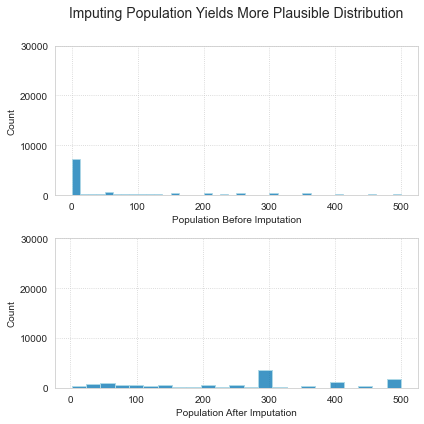

In [34]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6, 6))
sns.set_style(style="whitegrid",
              rc= {'patch.edgecolor': 'lightblue',
                   'grid.linestyle': ':'})

plt.subplot(2, 1, 1)
sns.histplot(data=pop_500_df, x='pre_impute_pop')
plt.title('Imputing Population Yields More Plausible Distribution',
          size=14,
          y=1.15)
plt.xlabel('Population Before Imputation')
plt.yticks(range(0, 40000, 10000))

plt.subplot(2, 1, 2)
sns.histplot(data=pop_500_df, x='post_impute_pop')
plt.yticks(range(0, 40000, 10000))
plt.xlabel('Population After Imputation')

plt.tight_layout()
plt.show()

## public_meeting

In [35]:
print(train_features['public_meeting'].value_counts())
train_features['public_meeting'].fillna(True, inplace=True)

True     12738
False     1291
Name: public_meeting, dtype: int64


## recorded_by

In [36]:
train_features['recorded_by'].describe()

count                       14850
unique                          1
top       GeoData Consultants Ltd
freq                        14850
Name: recorded_by, dtype: object

## scheme_management and scheme_name

In [37]:
replace_na_region_district_mode(train_features, 'scheme_management')

## permit

In [38]:
permit_mode = (train_features['permit'].mode())[0]
print(train_features['permit'].value_counts())
print('Number of NaNs:', train_features['permit'].isna().sum())

True     9754
False    4359
Name: permit, dtype: int64
Number of NaNs: 737


In [39]:
replace_na_region_district_mode(train_features, 'permit')

In [40]:
train_features['permit'].isna().sum()

346

In [41]:
train_features['permit'].fillna(permit_mode, inplace=True)

## construction_year

In [42]:
# Missing values listed as 0
train_features.loc[train_features['construction_year'] == 0, 'construction_year'] = np.nan
print('There are {} waterpoints with construction_year of NaN'.format(
      train_features['construction_year'].isna().sum()))

There are 5260 waterpoints with construction_year of NaN


In [43]:
# Use median to impute due to distribution with long left tail
fill_na_median_area(df=train_features, num_col='construction_year')
train_features['construction_year'] = train_features['construction_year'].astype('int')

In [44]:
train_features['date_recorded'] = pd.to_datetime(train_features['date_recorded'])
train_features['construction_year'] = pd.to_datetime(train_features['construction_year'], format='%Y')
train_features['years_elapsed'] = train_features['date_recorded'].dt.year - train_features['construction_year'].dt.year

In [45]:
train_features[train_features['years_elapsed'] < 0][['date_recorded', 
                                                           'construction_year', 
                                                           'years_elapsed']]
print('Wells with negative years_elapsed:', train_features[train_features['years_elapsed'] < 0].shape[0])
train_features.loc[train_features['years_elapsed'] < 0, 'years_elapsed'] = 0
print('Wells with negative years_elapsed:', train_features[train_features['years_elapsed'] < 0].shape[0])

Wells with negative years_elapsed: 4
Wells with negative years_elapsed: 0


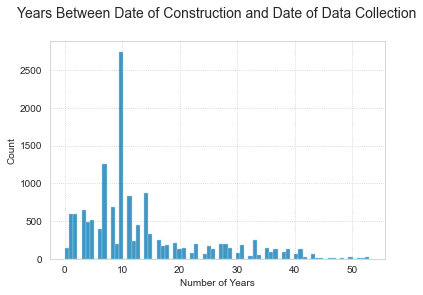

In [46]:
sns.histplot(data=train_features, x='years_elapsed')
plt.title('Years Between Date of Construction and Date of Data Collection', 
          size=14,
          y=1.08)
plt.xlabel('Number of Years')
plt.show()

## extraction_type, extraction_type_group, extraction_type_class

In [47]:
train_features.groupby(['extraction_type', 'extraction_type_group', 'extraction_type_class']).size()

extraction_type    extraction_type_group  extraction_type_class
afridev            afridev                handpump                  438
cemo               other motorpump        motorpump                  18
climax             other motorpump        motorpump                   9
gravity            gravity                gravity                  6483
india mark ii      india mark ii          handpump                  629
india mark iii     india mark iii         handpump                   37
ksb                submersible            submersible               375
mono               mono                   motorpump                 763
nira/tanira        nira/tanira            handpump                 2051
other              other                  other                    1672
other - play pump  other handpump         handpump                   16
other - rope pump  rope pump              rope pump                 121
other - swn 81     other handpump         handpump                   55


## management and management_group

In [48]:
train_features.groupby(['management', 'management_group']).size()

management        management_group
company           commercial            174
other             other                 239
other - school    other                  27
parastatal        parastatal            461
private operator  commercial            533
trust             commercial             27
unknown           unknown               122
vwc               user-group          10117
water authority   commercial            219
water board       user-group            755
wua               user-group            583
wug               user-group           1593
dtype: int64

## payment and payment_type

In [49]:
train_features.groupby(['payment', 'payment_type']).size()

payment                payment_type
never pay              never pay       6364
other                  other            260
pay annually           annually         928
pay monthly            monthly         2097
pay per bucket         per bucket      2281
pay when scheme fails  on failure       928
unknown                unknown         1992
dtype: int64

## water_quality and quality_group

In [50]:
train_features.groupby(['water_quality', 'quality_group']).size()

water_quality       quality_group
coloured            colored            133
fluoride            fluoride            44
fluoride abandoned  fluoride             6
milky               milky              201
salty               salty             1226
salty abandoned     salty               84
soft                good             12687
unknown             unknown            469
dtype: int64

## quantity and quantity_group

In [51]:
train_features.groupby(['quantity', 'quantity_group']).size()

quantity      quantity_group
dry           dry               1536
enough        enough            8336
insufficient  insufficient      3767
seasonal      seasonal          1025
unknown       unknown            186
dtype: int64

## source, source_type, source_class

In [52]:
train_features.groupby(['source', 'source_type', 'source_class']).size()

source                source_type           source_class
dam                   dam                   surface          184
hand dtw              borehole              groundwater      234
lake                  river/lake            surface          185
machine dbh           borehole              groundwater     2747
other                 other                 unknown           49
rainwater harvesting  rainwater harvesting  surface          568
river                 river/lake            surface         2352
shallow well          shallow well          groundwater     4316
spring                spring                groundwater     4195
unknown               other                 unknown           20
dtype: int64

## waterpoint_type and waterpoint_type_group

In [53]:
train_features.groupby(['waterpoint_type', 'waterpoint_type_group']).size()

waterpoint_type              waterpoint_type_group
cattle trough                cattle trough              34
communal standpipe           communal standpipe       7106
communal standpipe multiple  communal standpipe       1508
dam                          dam                         1
hand pump                    hand pump                4396
improved spring              improved spring           175
other                        other                    1630
dtype: int64

# Convert any remaining 'object' features that contain upper case to lower case

In [54]:
object_features = train_features.select_dtypes(include=["object"]).columns.tolist()
print("Names of object columns : ", object_features)

for feature in object_features:
    train_features[feature] = train_features[feature].str.lower()
    
train_features.iloc[0]

Names of object columns :  ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


id                                         50785
amount_tsh                                  20.0
date_recorded                2013-02-04 00:00:00
funder                                      dmdd
gps_height                                1996.0
installer                                   dmdd
longitude                              35.290799
latitude                               -4.059696
wpt_name                 dinamu secondary school
num_private                                    0
basin                                   internal
subvillage                                magoma
region                                   manyara
region_code                                   21
district_code                                  3
lga                                        mbulu
ward                                      bashay
population                                   321
public_meeting                              True
recorded_by              geodata consultants ltd
scheme_management   

In [55]:
train_features.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,years_elapsed
count,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,37161.972929,637.876141,1075.688182,35.099491,-5.770438,0.415084,15.139057,5.626397,352.647003,13.279798
std,21359.364833,2704.673103,513.408599,2.587550,2.811968,8.167910,17.191329,9.673842,450.967628,10.327659
min,10.000000,0.200000,-57.000000,29.612776,-11.564592,0.000000,1.000000,0.000000,2.000000,0.000000
25%,18727.000000,50.000000,823.000000,33.235554,-8.443970,0.000000,5.000000,2.000000,150.000000,7.000000
50%,37361.500000,250.000000,1191.000000,34.901215,-5.049750,0.000000,12.000000,3.000000,300.000000,10.000000
75%,55799.750000,500.000000,1340.000000,37.196594,-3.320976,0.000000,17.000000,5.000000,400.000000,16.000000
max,74249.000000,200000.000000,2777.000000,40.325016,-0.998752,669.000000,99.000000,80.000000,11469.000000,53.000000


In [57]:
now = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
train_features.to_csv('../data/processed/train_features_clean_{}'.format(now, index=False))
#train_features.to_csv('../data/processed/test_features_clean_{}'.format(now, index=False))